## Spatial frequency study

In [2]:
# load all the packages and libraries going to be used
%pylab inline
from mvpa2.suite import *
import os.path as op
import sklearn
import seaborn as sns
from pywt import wavedecn
from scipy import stats
from mpl_toolkits import mplot3d
from scipy.io import loadmat

Populating the interactive namespace from numpy and matplotlib


/anaconda3/envs/py2/lib/python2.7/site-packages/mvpa2/testing/tools.py:81: DeprecationWarning: Importing from numpy.testing.decorators is deprecated since numpy 1.15.0, import from numpy.testing instead.
  from numpy.testing.decorators import skipif


In [3]:
# First, let's load fMRI data, 10 runs
subjects = 's11'
bold_fname = ('all_subjects_18'+'/'+subjects+'.nii/01.nii','all_subjects_18'+'/'+subjects+'.nii/02.nii','all_subjects_18'+'/'+subjects+'.nii/03.nii','all_subjects_18'+'/'+subjects+'.nii/04.nii','all_subjects_18'+'/'+subjects+'.nii/05.nii','all_subjects_18'+'/'+subjects+'.nii/06.nii','all_subjects_18'+'/'+subjects+'.nii/07.nii','all_subjects_18'+'/'+subjects+'.nii/08.nii','all_subjects_18'+'/'+subjects+'.nii/09.nii','all_subjects_18'+'/'+subjects+'.nii/10.nii')

ds= fmri_dataset(bold_fname)
print 'sample_number=',len(ds)  # check how many samples or volumes;
print'feature_number=',ds.nfeatures # check how many feature are there;
print'data_info=',ds.shape # check teh 2-dimensianl dataset info;

 * Please note: warnings are printed only once, but underlying problem might occur many times *
sample_number= 1230
feature_number= 172800
data_info= (1230, 172800)


In [4]:
VT = loadmat ("all_subjects_18/vt.mat") #load mat.file into python.
VT = VT['VT'] #get the value out of dictionary
BA17 = loadmat("all_subjects_18/BA17.mat")
BA17 = BA17['BA17']

In [6]:
# Load in the mask of the ROI
ds = fmri_dataset (bold_fname, mask= BA17)
print 'sample_number=',len(ds)  # check how many samples or volumes;
print'feature_number=',ds.nfeatures # check how many feature being used;
print'data_info=',ds.shape # check teh 2-dimensianl dataset info;

sample_number= 1230
feature_number= 240
data_info= (1230, 240)


In [7]:
# explore the dataset attributes
print 'TR_index=', ds.sa.time_indices[:5]
print 'Actual time of TR=', ds.sa.time_coords[:5]
print 'ori_voxel_feature=', ds.fa.voxel_indices[:5] # Just take a look of the first five feature, we can see the spatial info is preseverd!
print 'voxel_size=', ds.a.voxel_eldim
print 'volumes_dim=', ds.a.voxel_dim

TR_index= [0 1 2 3 4]
Actual time of TR= [0. 2. 4. 6. 8.]
ori_voxel_feature= [[17 58 18]
 [17 58 19]
 [18 58 18]
 [18 58 19]
 [19 58 18]]
voxel_size= (3.0, 3.0, 3.0)
volumes_dim= (54, 64, 50)


In [8]:
#ds.a.mapper # Since the the most important feature of this toolbox is everything
            # can be reversed back. why? Becaused everything has been recored! How cool 
            # is that!
# stripped = ds.copy(deep=False, sa=['time_coords'],fa=[],a=[])
# Print stripped
# Having all these attributes being part of a dataset is often a useful thing to have, but in some cases (e.g. when it
# comes to efficiency, and/or very large datasets) one might want to have a leaner dataset with just the information
# that is really necessary. One way to achieve this, is to strip all unwanted attributes. The Dataset class’ copy()
# method can help with that.

In [9]:
#np.mean(ds)
#sns.heatmap(ds)

In [8]:
# Load in the condition label file
conditions=loadmat('all_subjects_18/regressors_sh3.mat')
conditions = conditions['regressors_sh3']
conditions.shape

(12, 1230)

In [9]:
def convert_binary_to_multiclass(binary_conditions):
    """Convert binary representation into multiclass reprentation:
    For example: convert [[1 1 1 1 0 0 0 0]
                          [0 0 0 0 1 1 1 1]]
    to [1 1 1 1 2 2 2 2]"""
    x,y = np.where(binary_conditions)
    conditions=np.zeros(binary_conditions.shape[1])
    conditions[y]=x+1
    return conditions

conditions_multi = convert_binary_to_multiclass(conditions)
conditions_multi[:123]#first run

array([ 0.,  0.,  0.,  0.,  0.,  8.,  8.,  8.,  8.,  0.,  0.,  0.,  0.,
        0.,  0.,  7.,  7.,  7.,  7.,  0.,  0.,  0.,  0.,  0.,  0., 11.,
       11., 11., 11.,  0.,  0.,  0.,  0.,  0.,  0.,  9.,  9.,  9.,  9.,
        0.,  0.,  0.,  0.,  0.,  0.,  5.,  5.,  5.,  5.,  0.,  0.,  0.,
        0.,  0.,  0., 10., 10., 10., 10.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  3.,  3.,
        3.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,  2.,  2.,  0.,  0.,
        0.,  0.,  0.,  0., 12., 12., 12., 12.,  0.,  0.,  0.,  0.,  0.,
        0.,  4.,  4.,  4.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  6.,  6.,
        6.,  6.,  0.,  0.,  0.,  0.])

In [10]:
# Load in runs
runs=loadmat('all_subjects_18/runs.mat')
runs = runs['runs']
runs = runs[0,:] #get rid of the rows. 
runs.shape

(1230,)

In [11]:
ds = fmri_dataset (bold_fname, mask = BA17, targets= conditions_multi, chunks=runs)
# ds = fmri_dataset (bold_fname, mask=BA17, targets= conditions_multi, chunks=runs)

print ds.summary()

Dataset: 1230x240@float32, <sa: chunks,targets,time_coords,time_indices>, <fa: voxel_indices>, <a: imgaffine,imghdr,imgtype,mapper,voxel_dim,voxel_eldim>
stats: mean=-3.12157e-06 std=2.37657 var=5.6481 min=-63.0634 max=53.5295

Counts of targets in each chunk:
  chunks\targets 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0
                 --- --- --- --- --- --- --- --- --- ---  ---  ---  ---
        1         75  4   4   4   4   4   4   4   4   4    4    4    4
        2         75  4   4   4   4   4   4   4   4   4    4    4    4
        3         75  4   4   4   4   4   4   4   4   4    4    4    4
        4         75  4   4   4   4   4   4   4   4   4    4    4    4
        5         75  4   4   4   4   4   4   4   4   4    4    4    4
        6         75  4   4   4   4   4   4   4   4   4    4    4    4
        7         75  4   4   4   4   4   4   4   4   4    4    4    4
        8         75  4   4   4   4   4   4   4   4   4    4    4    4
        9         75  4   4

In [73]:
import plotly.graph_objs as go
vol=ds.fa.voxel_indices
x = vol[:,0]
y = vol[:,1]
z = vol[:,2]

fig1 = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,mode='markers',marker=dict(
        size=7,
        color=np.ravel(ds[0,:]),                # set color to an array/list of desired values
        colorscale='Rainbow',   # choose a colorscale
        opacity=0.8,
    colorbar_title = '1st TR'
    ))])

fig1.show()

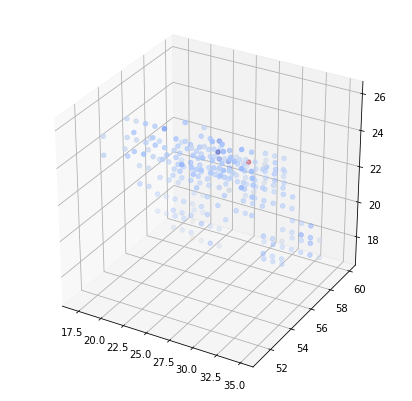

In [74]:
fig = plt.figure(figsize= (7,7))
ax = plt.axes(projection='3d')
vol=ds.fa.voxel_indices
x = vol[:,0]
y = vol[:,1]
z = vol[:,2]
ax.scatter3D(x,y,z, c= np.ravel(ds[0,:]),cmap='coolwarm') #ravel to conpress; Let's look at the first TR within 92 TR
# Good demonstration that spatial info can be preserved

In [12]:
insect1 = ds.targets == 1
insect2 = ds.targets == 2
insect3 = ds.targets == 3
insect4 = ds.targets == 4
bird1 = ds.targets == 5
bird2 = ds.targets == 6
bird3 = ds.targets == 7
bird4 = ds.targets == 8
monkey1 = ds.targets == 9
monkey2 = ds.targets == 10
monkey3 = ds.targets == 11
monkey4 = ds.targets == 12

In [13]:
insect1_allTR = ds[insect1,:]
insect2_allTR = ds[insect2,:]
insect3_allTR = ds[insect3,:]
insect4_allTR = ds[insect4,:]
insect1_mean = np.mean(insect1_allTR,axis=0)
insect2_mean = np.mean(insect2_allTR,axis=0)
insect3_mean = np.mean(insect3_allTR,axis=0)
insect4_mean = np.mean(insect4_allTR,axis=0)

bird1_allTR = ds[bird1,:]
bird2_allTR = ds[bird2,:]
bird3_allTR = ds[bird3,:]
bird4_allTR = ds[bird4,:]
bird1_mean = np.mean(bird1_allTR,axis=0)
bird2_mean = np.mean(bird2_allTR,axis=0)
bird3_mean = np.mean(bird3_allTR,axis=0)
bird4_mean = np.mean(bird4_allTR,axis=0)

monkey1_allTR = ds[monkey1,:]
monkey2_allTR = ds[monkey2,:]
monkey3_allTR = ds[monkey3,:]
monkey4_allTR = ds[monkey4,:]
monkey1_mean = np.mean(monkey1_allTR,axis=0)
monkey2_mean = np.mean(monkey2_allTR,axis=0)
monkey3_mean = np.mean(monkey3_allTR,axis=0)
monkey4_mean = np.mean(monkey4_allTR,axis=0)



import plotly.graph_objs as go
vol=ds.fa.voxel_indices
x = vol[:,0]
y = vol[:,1]
z = vol[:,2]

animal = [insect1_mean,insect2_mean,insect3_mean,insect4_mean,bird1_mean,bird2_mean,bird3_mean,bird4_mean,monkey1_mean,monkey2_mean,monkey3_mean,monkey4_mean]
animal_titles = ["insect1_mean","insect2_mean","insect3_mean","insect4_mean","bird1_mean","bird2_mean","bird3_mean","bird4_mean","monkey1_mean","monkey2_mean","monkey3_mean","monkey4_mean"]

fig1 = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,mode='markers',marker=dict(
        size=7,
        color=np.ravel(animal[1]),                # set color to an array/list of desired values
        colorscale='Rainbow',   # choose a colorscale
        opacity=0.8,
    colorbar_title = '1st TR'
    ))])

fig1.show()

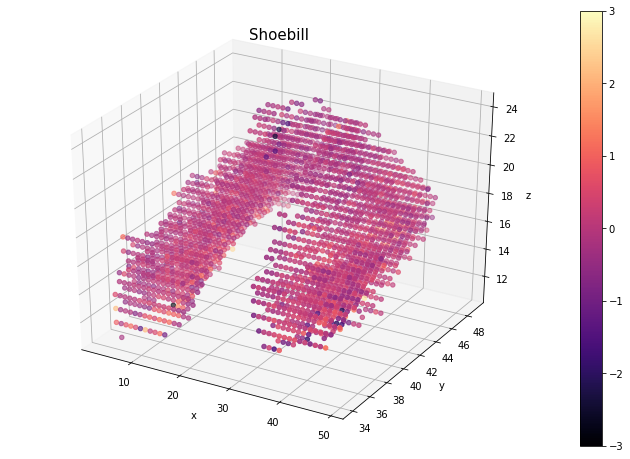

In [115]:
vol=ds.fa.voxel_indices
x = vol[:,0]
y = vol[:,1]
z = vol[:,2]

# Here I ploted 12 objects, each one has many pictures, so we goanna look at the mean pic of each.
#animal = [insect1_mean,insect2_mean,insect3_mean,insect4_mean,bird1_mean,bird2_mean,bird3_mean,bird4_mean,monkey1_mean,monkey2_mean,monkey3_mean,monkey4_mean]
animal = [bird4_mean]
#animal_titles = ["insect1_mean","insect2_mean","insect3_mean","insect4_mean","bird1_mean","bird2_mean","bird3_mean","Shoebill","monkey1_mean","monkey2_mean","monkey3_mean","monkey4_mean"]
animal_titles = ["Shoebill"]
for i in range(len(animal)):
    fig = plt.figure(figsize= (12,8))
    ax = plt.axes(projection='3d')
    p =ax.scatter3D(x,y,z, c= np.ravel(animal[i]),cmap='magma',vmin=-3, vmax=3)
    #p=plt.scatter(x,y, c= np.ravel(animal[i]),cmap='seismic')#vmin=-3, vmax=3)
    fig.colorbar(p)
    ax.set_title (animal_titles[i],fontsize=15)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    plt.savefig("VT_shoebill")

In [117]:
animal[i]

array([ 0.38071832,  1.1029385 ,  0.42863232, ...,  0.50981164,
       -0.3540147 , -0.58473474], dtype=float32)

from statsmodels.stats.multicomp import pairwise_tukeyhsd
perform multiple pairwise comparison (Tukey HSD)
m_comp = pairwise_tukeyhsd(endog=d_melt['value'], groups=d_melt['treatments'], alpha=0.05)
#print(m_comp_res)
- https://reneshbedre.github.io/blog/anova.html

In [14]:
orig_data = ds.a.mapper.reverse(ds.samples) #data plus spatial information 3d matrix
orig_data.shape #x,y,z indicates voxel numbers alone axies

(1230, 54, 64, 50)

In [15]:
#new_data = VT * orig_data
new_data = BA17 * orig_data  # use BA17 instead
new_data.shape

(1230, 54, 64, 50)

In [16]:
from matplotlib.pylab import *
import dtcwt

In [62]:
new_data[monkey1,:,:,:].shape  # this is how to get the trs corresponding to monkey1

# for any monkeys, it's a logical or 
monkeys_12 = np.logical_or(monkey1,monkey2)
monkeys_34 = np.logical_or(monkey3,monkey4)
any_monkeys = np.logical_or(monkeys_12,monkeys_34)

In [63]:
# look at monkey only
new_data_monkey = new_data[any_monkeys,:,:,:]
new_data_monkey.shape
monkeys_mean = new_data_monkey.mean(axis=0)
monkeys_mean.shape

(54, 64, 50)

In [64]:
new_data_monkey.shape

(160, 54, 64, 50)

In [48]:
var_L1=[]
var_L2=[]
var_L3=[]
var_L4=[]
var_L5=[]

trans = dtcwt.Transform3d()

#animals = [insect1,insect2,insect3,insect4,bird1,bird2,bird3,bird4,monkey1,monkey2,monkey3,monkey4]
for i in range(16, 17):  # TR = 5, animal = 8
# for i in range(new_data.shape[0]): #transform all 1230 trs
    TR=new_data[i,:,:,:]
    wvt = trans.forward(TR,nlevels=5)
    
    # level 1:
    highpasses = wvt.highpasses[0]
    var_per_orientation = highpasses.var(axis=(0,1,2)) #0,1,2 means take var across x,y,z, because it is a 3d volume
    #total_var = np.mean(var_per_orientation)  
    var_L1.append(var_per_orientation)
    
    # level 2:
    highpasses = wvt.highpasses[1]
    var_per_orientation = highpasses.var(axis=(0,1,2))
    #total_var = np.mean(var_per_orientation)
    var_L2.append(var_per_orientation)
    
    # level 3:
    highpasses = wvt.highpasses[2]
    var_per_orientation = highpasses.var(axis=(0,1,2))
    #total_var = np.mean(var_per_orientation) 
    var_L3.append(var_per_orientation)
    
    # level 4:
    highpasses = wvt.highpasses[3]
    var_per_orientation = highpasses.var(axis=(0,1,2))
    #total_var = np.mean(var_per_orientation)  
    var_L4.append(var_per_orientation)
    
    # level 5:
    highpasses = wvt.highpasses[4]
    var_per_orientation = highpasses.var(axis=(0,1,2))
    #total_var = np.mean(var_per_orientation)  
    var_L5.append(var_per_orientation)
    

print var_L1
#print mean_var_L2
#print mean_var_L3
#print mean_var_L4
#print mean_var_L5

[array([0.00262831, 0.00246203, 0.00279395, 0.00280279, 0.00200171,
       0.00204448, 0.00230162, 0.00216393, 0.00206231, 0.00222173,
       0.00232908, 0.0025107 , 0.00133513, 0.00135813, 0.00146174,
       0.00147423, 0.00122082, 0.0011491 , 0.00144646, 0.00139911,
       0.00193508, 0.00200365, 0.00230247, 0.00211154, 0.00198041,
       0.00218813, 0.0022883 , 0.00244722], dtype=float32)]


In [45]:
wvt.highpasses[1].shape

(14, 16, 13, 28)

In [50]:
np.log(0)

/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


-inf

In [51]:
# plot the coefficients for each scale. #animal 7
for i in range(1):
    a = wvt.highpasses[i]
    a = np.ma.log(abs(a))
    va = a.var(axis=(0,1,2))

(array([1., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 3., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 3., 2., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1.]),
 array([ 7.42086439,  7.46994223,  7.51902006,  7.5680979 ,  7.61717574,
         7.66625358,  7.71533142,  7.76440925,  7.81348709,  7.86256493,
         7.91164277,  7.9607206 ,  8.00979844,  8.05887628,  8.10795412,
         8.15703196,  8.20610979,  8.25518763,  8.30426547,  8.35334331,
         8.40242114,  8.45149898,  8.50057682,  8.54965466,  8.59873249,
         8.64781033,  8.69688817,  8.74596601,  8.79504385,  8.84412168,
         8.89319952,  8.94227736,  8.9913552 ,  9.04043303,  9.08951087,
         9.13858871,  9.18766655,  9.23

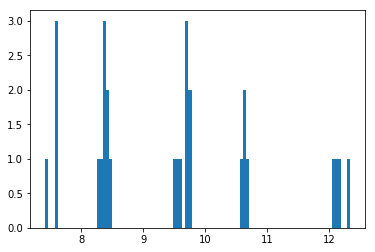

In [54]:
va.shape
plt.hist(va, bins = 100)

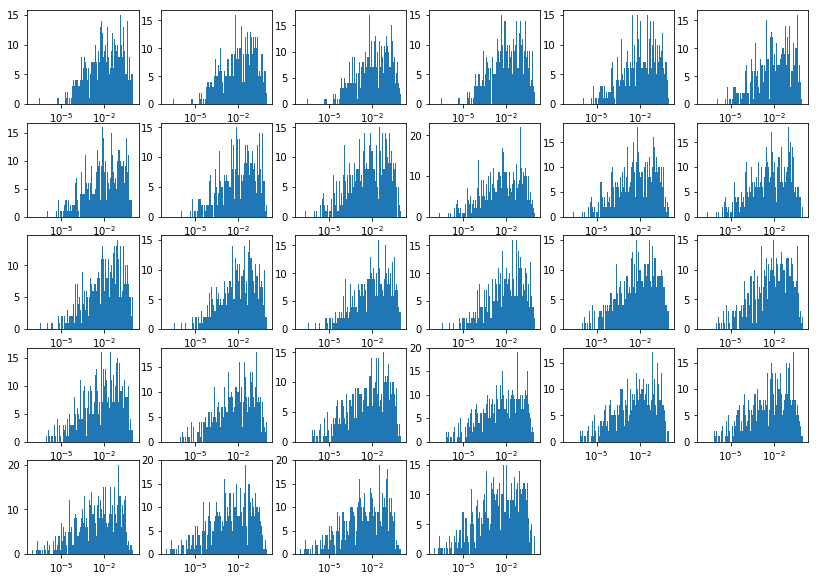

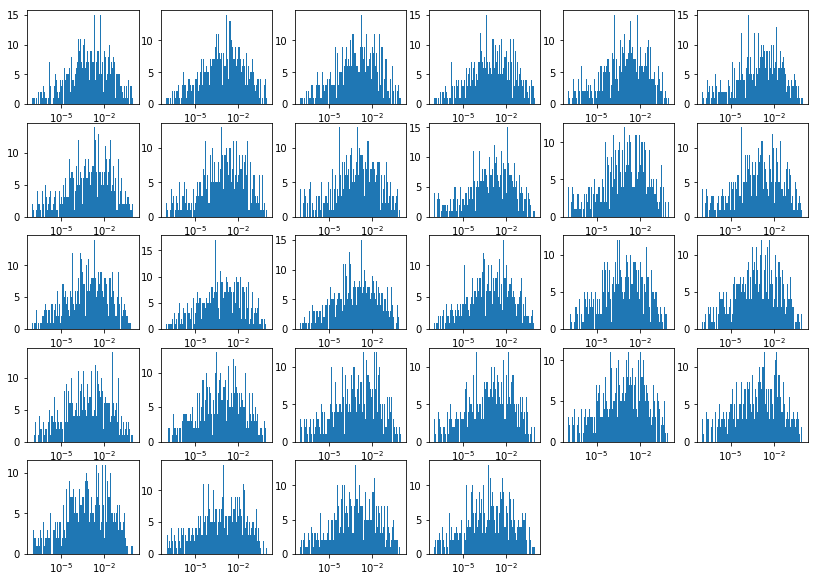

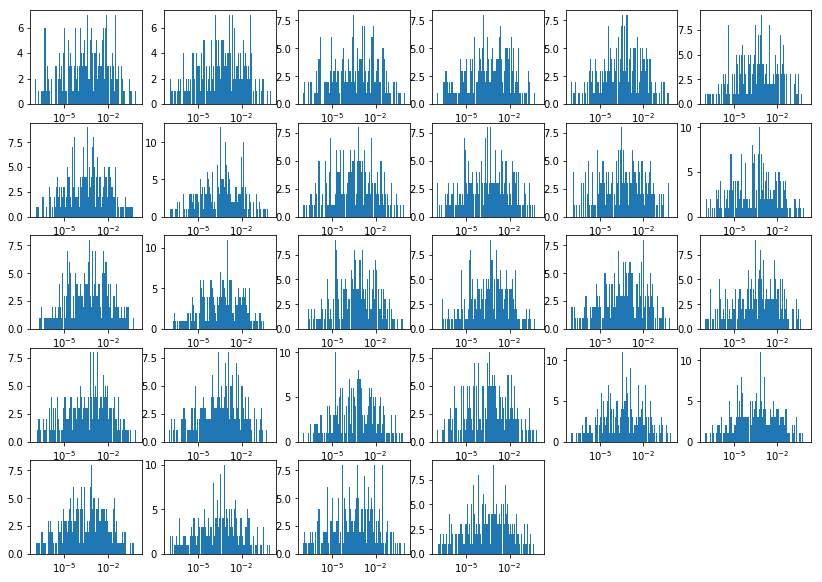

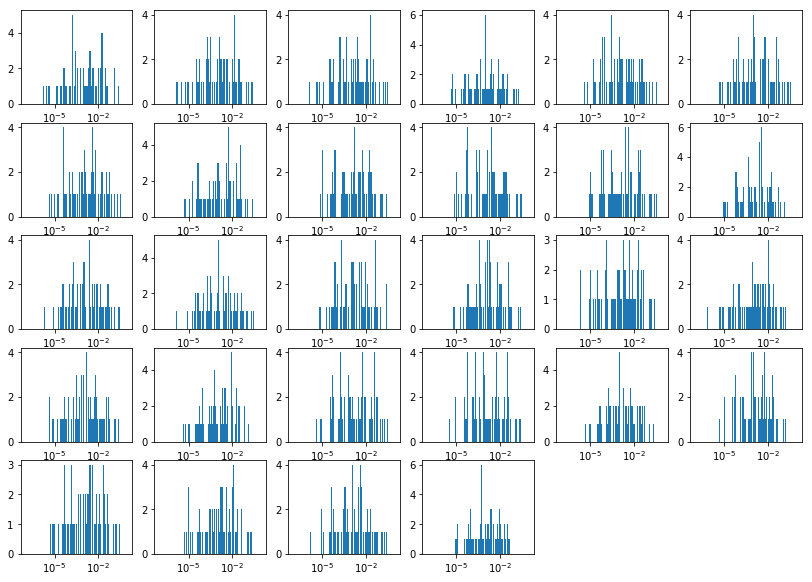

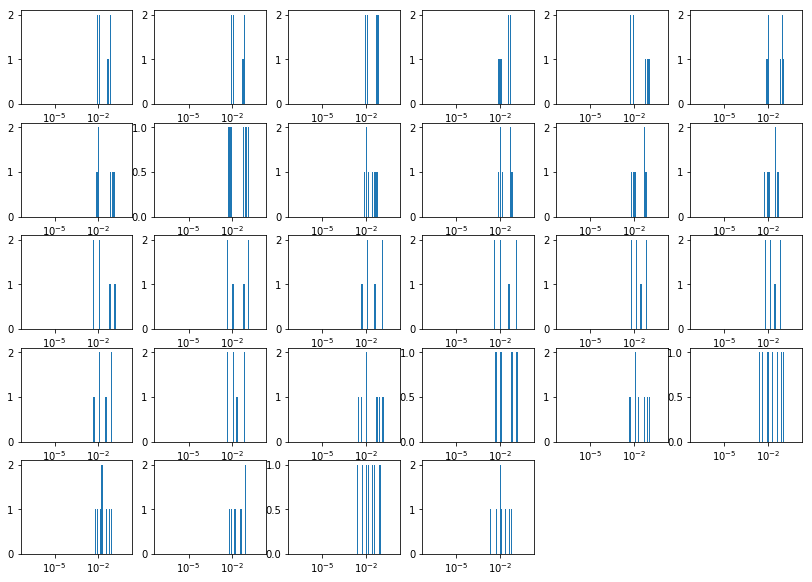

In [49]:
# plot the coefficients for each scale. #animal 7
for i in range(5):
    plt.figure(figsize = (14,10))
    for j in range(28):
        plt.subplot(5,6,j+1)
        a = wvt.highpasses[i][:,:,:,j]  
        a = abs(a [a!=0])
        #b = a.ravel()
        plt.hist(a, bins = np.logspace(-7,0,100));
        #plt.yscale('log')
        plt.xscale('log')

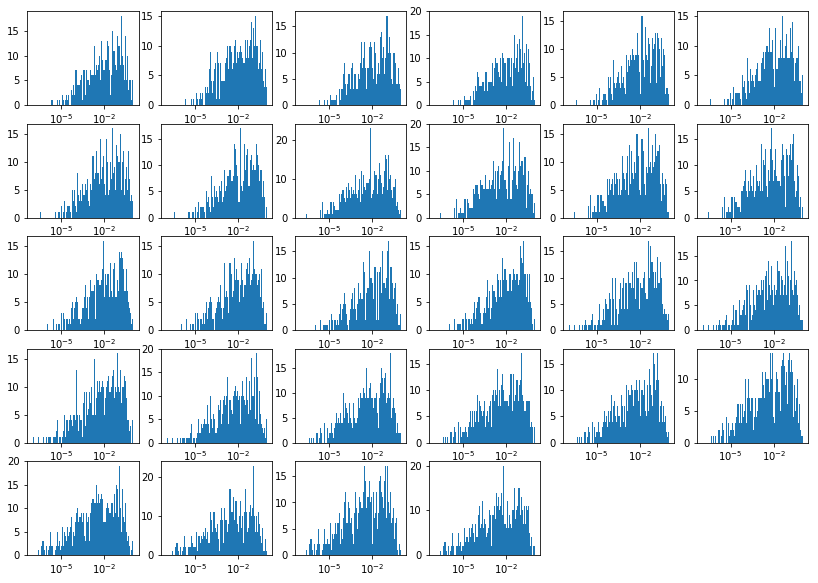

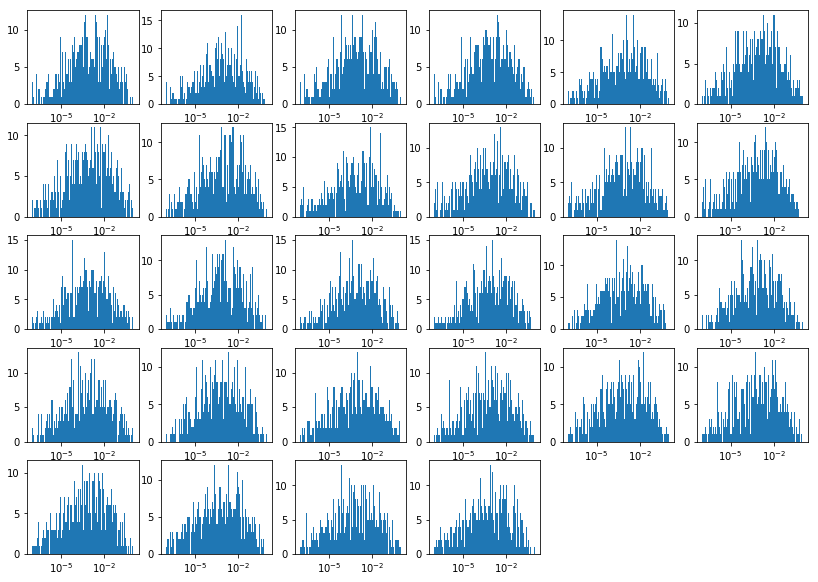

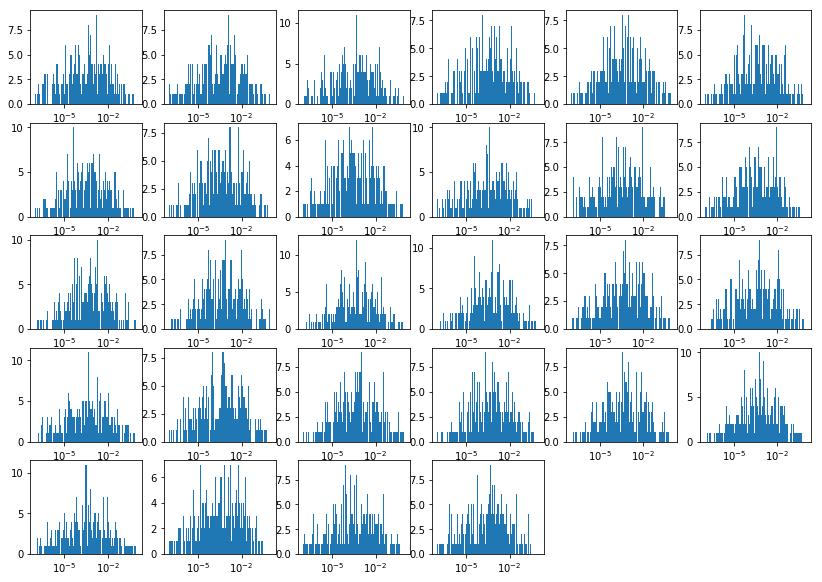

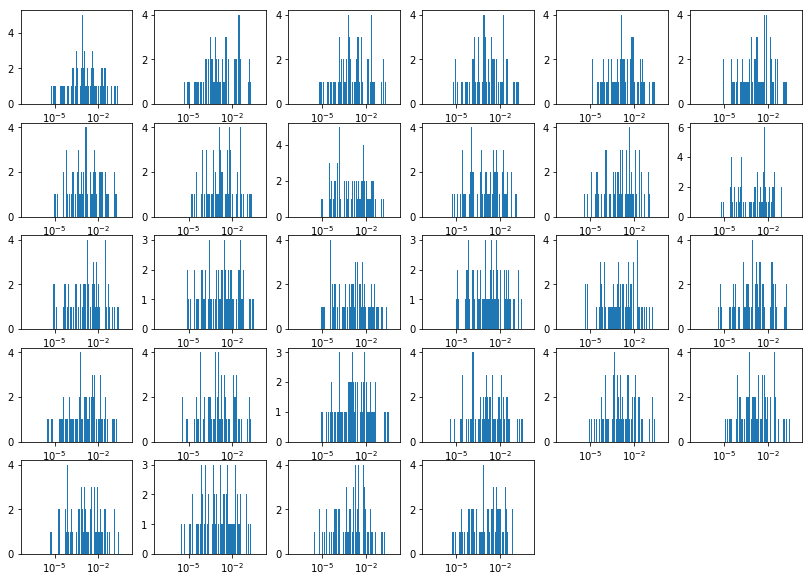

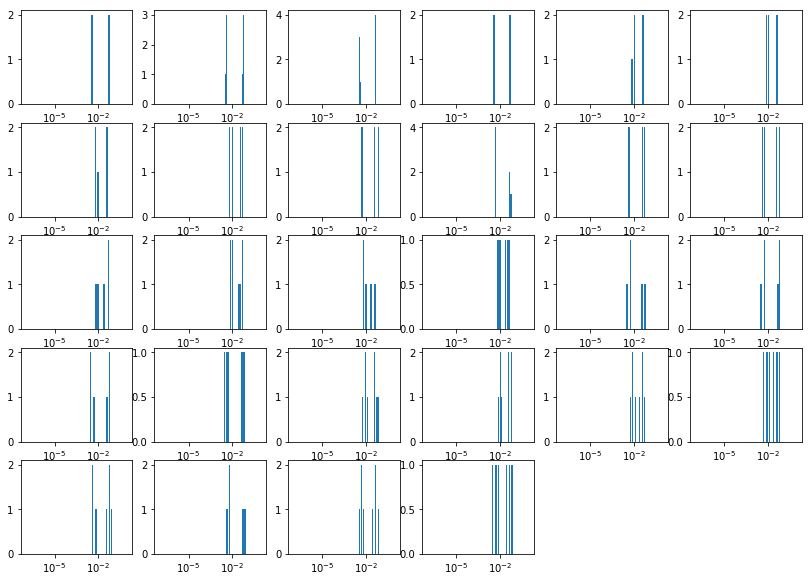

In [47]:
# plot the coefficients for each scale. #animal 8
for i in range(5):
    plt.figure(figsize = (14,10))
    for j in range(28):
        plt.subplot(5,6,j+1)
        a = wvt.highpasses[i][:,:,:,j]
        a = abs(a[a != 0])
        #b = a.ravel()
        plt.hist(a, bins = np.logspace(-7,0,100));
        #plt.yscale('log')
        plt.xscale('log')

In [66]:
# visualize the coefficients
#
# first, look at the shape at each level
for i in range(5):
    print(wvt.highpasses[i].shape)

(27, 32, 25, 28)
(14, 16, 13, 28)
(7, 8, 7, 28)
(4, 4, 4, 28)
(2, 2, 2, 28)


0.0008873362
0.0018989505
0.00056821725
0.00397046
0.0011151744


<Figure size 432x288 with 0 Axes>

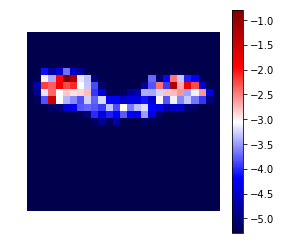

<Figure size 432x288 with 0 Axes>

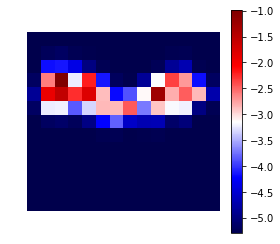

<Figure size 432x288 with 0 Axes>

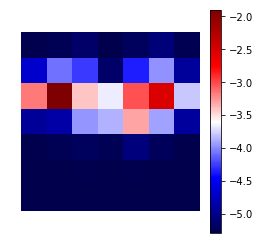

<Figure size 432x288 with 0 Axes>

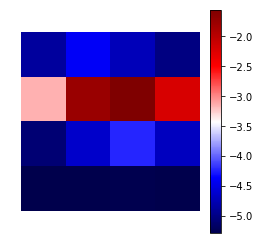

<Figure size 432x288 with 0 Axes>

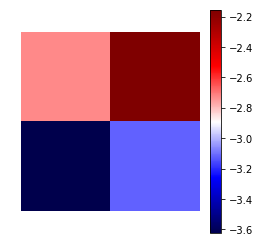

In [70]:
# take the example of the first orientation 
# and try to make a projection on one of the axis
orient_id = 0
projection_axis = 1

# make a variance projection of x
for i in range(5):
    projection = np.var(wvt.highpasses[i], axis=projection_axis)[...,orient_id]
    plt.figure()
    data = projection.T
    print(np.var(data))
    #data -= np.mean(data)
    plt.matshow(np.log(data+0.005),cmap='seismic')  # used for VT
    # plt.matshow(np.log(data+0.005),cmap='seismic')  # for BA17
    plt.colorbar()
    plt.axis('off')
    #plt.savefig("VT_%s.png" %i, bbox_inches='tight')

In [24]:
len(wvt.highpasses[4])

2

In [25]:
new_data.shape
#TR.shape

(1230, 54, 64, 50)

In [26]:
L1_ALLTR=numpy.vstack( var_L1 )
L2_ALLTR=numpy.vstack( var_L2 )
L3_ALLTR=numpy.vstack( var_L3 )
L4_ALLTR=numpy.vstack( var_L4 )
L5_ALLTR=numpy.vstack( var_L5 )

In [27]:
ALL_Level_TR=numpy.stack([L1_ALLTR,L2_ALLTR,L3_ALLTR,L4_ALLTR,L5_ALLTR], axis=1)#vstack can only take a list;
#why not vstack as above, because it's no longer intuitive whether it is horizontal or vertical stack so use "stack"
# and specify the axis directly. 

In [28]:
#L1_ALLTR.shape
ALL_Level_TR.shape #1230 TR, 5 levels, each level 28 orientations. 
np.save("all_levels_for_all_TR_s11",ALL_Level_TR)

In [29]:
for highpasses in wvt.highpasses:
    print(highpasses.shape) #x,y,z voxels numbers at different axis, 28 orientations.
    #from this code we can see that the first level is the finer grain, the last level is coarser grain. Dimention reduction. 

(27, 32, 25, 28)
(14, 16, 13, 28)
(7, 8, 7, 28)
(4, 4, 4, 28)
(2, 2, 2, 28)


In [30]:
animals = ["insect1","insect2","insect3","insect4","bird1","bird2","bird3","bird4","monkey1","monkey2","monkey3","monkey4"]
animals [8:12]

['monkey1', 'monkey2', 'monkey3', 'monkey4']

In [31]:
mean_var_L1_arr = np.array(mean_var_L1)

NameError: name 'mean_var_L1' is not defined

In [ ]:

mean_var_5l=[]
# loop over TR
for i in range(new_data.shape[0]):
    TR=new_data[i,:,:,:]
    coeff = pywt.wavedecn(TR, 'haar')
    len(coeff)
    len(coeff[-1])

    
    sum_var=[]
    
    for j in range(len(coeff)-1): #loop over levels
        level=j+1
        # coeff[-level] is now a dictionary
        aad = coeff[-level]['aad']
        ada = coeff[-level]['ada']
        daa = coeff[-level]['daa']
        add = coeff[-level]['aad']
        dad = coeff[-level]['dad']
        dda = coeff[-level]['dda']
        ddd = coeff[-level]['ddd']
        sum_var.append(aad.var() +ada.var() +daa.var()+add.var() +dad.var() +dda.var()+ddd.var())
    sum_var_all.append(sum_var)
print 'sum var for all TRs=',sum_var_all # each numer describes the new feature for each level, then we have 5 new features based one 5 levels.

In [ ]:
coeff[2]['aad'].shape

In [ ]:
pl.figure(figsize=(14, 6))
pl.subplot(121)
plot_samples_distance(ds, sortbyattr='chunks')
pl.title('Distances: z-scored, detrended (sorted by chunks)')
pl.subplot(122)
plot_samples_distance(ds, sortbyattr='targets')
pl.title('Distances: z-scored, detrended (sorted by targets)')

In [ ]:
#preprocessing and get rid of resting state
poly_detrend(ds, polyord=1, chunks_attr='chunks')
zscore(ds, param_est=('targets', [0]))
ds = ds[ds.sa.targets != 0]

In [ ]:
pl.figure(figsize=(14, 6))
pl.subplot(121)
plot_samples_distance(ds, sortbyattr='chunks')
pl.title('Distances: z-scored, detrended (sorted by chunks)')
pl.subplot(122)
plot_samples_distance(ds, sortbyattr='targets')
pl.title('Distances: z-scored, detrended (sorted by targets)')

In [ ]:
clf = kNN(k=1, dfx=one_minus_correlation, voting='majority')
cvte = CrossValidation(clf, NFoldPartitioner(),errorfx=lambda p, t: np.mean(p == t))
cv_results = cvte(ds)
KNN_orig = np.mean(cv_results)
print 'Mean accuracy KNN_Orig=', KNN_orig
print
# test the significance
t, p = stats.ttest_1samp(cv_results,.25)
print 't_value=', t
print 'p_value_orig=', p
print
print 'Accuracy for each run=', cv_results.samples

In [ ]:
# Try different classifers-SVM
clf = LinearCSVMC()
cvte = CrossValidation(clf, NFoldPartitioner(),errorfx=lambda p, t: np.mean(p == t))
cv_results_svm= cvte(ds)
SVM_orig = np.mean(cv_results_svm)
print 'Mean accuracy SVM_orig=',SVM_orig
print
# Test the results significance
t_svm, p_svm= stats.ttest_1samp(cv_results_svm,.25)
print
print 't_value_svm=', t_svm
print 'p_value_svm=', p_svm

In [ ]:
# Try different classifers-GNB
clf = GNB()
cvte = CrossValidation(clf, NFoldPartitioner(),errorfx=lambda p, t: np.mean(p == t))
cv_results_gnb= cvte(ds)
GNB_orig = np.mean(cv_results_gnb)
print 'Mean accuracy GNB_orig=',GNB_orig
print
# Test the results significance
t_gnb, p_gnb= stats.ttest_1samp(cv_results_gnb,.25)
print
print 't_new_value_gnb=', t_gnb
print 'p_new_value_gnb=', p_gnb

## Define the function to capture the spreadness of our data. 

In [ ]:
ds = fmri_dataset(bold_fname, mask=mask_fname, targets=conditions, chunks=chunks)
print ds.summary()

In [ ]:
def cal_R_sq (v_i,x_i,y_i,z_i):
    """Define the function that is gonna be used for the feature extration"""
    x_c = sum(np.abs(v_i)*x_i)/sum(np.abs(v_i))
    y_c = sum(np.abs(v_i)*y_i)/sum(np.abs(v_i))
    z_c = sum(np.abs(v_i)*z_i)/sum(np.abs(v_i))
    R_2 = sum(((x_i-x_c)**2+(y_i-y_c)**2)*np.abs(v_i))/sum(np.abs(v_i))
    return R_2

In [ ]:
# turn the list above into array
new_five_feature = np.asarray(sum_var_all)
data_five_feature = np.hstack([ds, new_five_feature])
# Create a new dataset after adding in the additional label
ds_new = dataset_wizard(data_five_feature, targets=conditions, chunks=chunks)
ds_new.shape
print ds.shape
print new_five_feature.shape

In [ ]:
print new_five_feature

In [ ]:
pl.figure(figsize=(14, 6))
pl.subplot(121)
plot_samples_distance(ds_new, sortbyattr='chunks')
pl.title('Distances: z-scored, detrended (sorted by chunks)')
pl.subplot(122)
plot_samples_distance(ds_new, sortbyattr='targets')
pl.title('Distances: z-scored, detrended (sorted by targets)')

#preprocessing on the dataset with new features
poly_detrend(ds_new, polyord=1, chunks_attr='chunks')
zscore(ds_new, param_est=('targets', [0]))
ds_new = ds_new[ds_new.sa.targets != 0]

pl.figure(figsize=(14, 6))
pl.subplot(121)
plot_samples_distance(ds_new, sortbyattr='chunks')
pl.title('Distances: z-scored, detrended (sorted by chunks)')
pl.subplot(122)
plot_samples_distance(ds_new, sortbyattr='targets')
pl.title('Distances: z-scored, detrended (sorted by targets)')

In [ ]:
# Classification based on new feature added
clf = kNN(k=1, dfx=one_minus_correlation, voting='majority')
cvte = CrossValidation(clf, NFoldPartitioner(),errorfx=lambda p, t: np.mean(p == t))
cv_new_results = cvte(ds_new)
KNN_new = np.mean(cv_new_results)
print 'Mean Accuracy KNN_new=', KNN_new
# Test the results significance
print
t_new, p_new = stats.ttest_1samp(cv_new_results,.25)
print 't_new_value=', t_new
print 'p_new_value=', p_new
print
print 'Accuracy for each run=', cv_new_results.samples

In [ ]:
# Try different classifers-SVM
clf = LinearCSVMC()
cvte = CrossValidation(clf, NFoldPartitioner(),errorfx=lambda p, t: np.mean(p == t))
cv_results_svm= cvte(ds_new)
SVM_new = np.mean(cv_results_svm)
print 'Mean accuracy SVM=',SVM_new
print
# Test the results significance
t_new_svm, p_new_svm= stats.ttest_1samp(cv_new_results,.25)
print
print 't_new_value_svm=', t_new_svm
print 'p_new_value_svm=', p_new_svm

In [ ]:
# Try different classifers-GNB
clf = GNB()
cvte = CrossValidation(clf, NFoldPartitioner(),errorfx=lambda p, t: np.mean(p == t))
cv_results_gnb= cvte(ds_new)
GNB_new = np.mean(cv_results_gnb)
print 'Mean accuracy GNB=',GNB_new
print
# Test the results significance
t_new_gnb, p_new_gnb= stats.ttest_1samp(cv_results_gnb,.25)
print
print 't_new_value_gnb=', t_new_gnb
print 'p_new_value_gnb=', p_new_gnb

In [ ]:
# a= fmri_dataset('right_fus.nii')
# a.samples[:,a.fa['voxel_indices'][:,0] < 25] = 0
# nimg = map2nifti(a)
# nimg.to_filename('masktest.nii')

In [ ]:
a= fmri_dataset('right_fus.nii')
#a.samples[:,a.fa['voxel_indices'][:,0] < 25] = 0
#nimg = map2nifti(a)
#nimg.to_filename('masktest.nii')
# plt.hist(a.samples)

In [ ]:
a.samples;
np.sum(a.samples == 2);
np.sum(a.samples == 1);

In [ ]:
new_five_feature.shape

In [ ]:
words = ds.targets == 1
faces = ds.targets == 2
shapes = ds.targets == 3
numbers = ds.targets == 4

In [ ]:
words_allTR = ds[words,:]
faces_allTR = ds[faces,:]
shapes_allTR = ds[shapes,:]
numbers_allTR = ds[numbers,:]

In [ ]:
ds.targets.shape

In [ ]:
ds.shape

In [ ]:
words_five_num = new_five_feature[words,:]
faces_five_num = new_five_feature[faces,:]
shapes_five_num = new_five_feature[shapes,:]
numbers_five_num = new_five_feature[numbers,:]

print words_five_num.shape
print faces_five_num.shape
print shapes_five_num.shape
print numbers_five_num.shape

In [ ]:
# Since based on my theory, the first and last level will bear the most difference.
# So I would like to plot the first and the last scale level across four conditions. 

words_five_num_15 = words_five_num[:,[0,4]]
faces_five_num_15= faces_five_num [:,[0,4]]
shapes_five_num_15= shapes_five_num [:,[0,4]]
numbers_five_num_15= numbers_five_num [:,[0,4]]

words_five_num_15.shape

In [ ]:
# The fist and last levels.
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
ax1.set_title ('L1 vs L5',fontsize=15)
ax1.set_xlabel("L1")
ax1.set_ylabel("L5")

ax1.scatter(words_five_num_15[:,0],words_five_num_15[:,1], c='b', marker="x", label='words')
ax1.scatter(faces_five_num_15[:,0],faces_five_num_15[:,1], c='r', marker="s", label='faces')
ax1.scatter(shapes_five_num_15[:,0],shapes_five_num_15[:,1], c='k', marker="o", label='shapes')
ax1.scatter(numbers_five_num_15[:,0],numbers_five_num_15[:,1], c='g', marker="d", label='numbers')
plt.legend(loc='upper left');
plt.show()


In [ ]:
# Since based on my theory, the first and last level will bear the most difference.
# So I would like to plot the first and the last scale level across four conditions. 

words_five_num_24 = words_five_num[:,[1,3]]
faces_five_num_24= faces_five_num [:,[1,3]]
shapes_five_num_24= shapes_five_num [:,[1,3]]
numbers_five_num_24= numbers_five_num [:,[1,3]]


In [ ]:
# The the second and fourth levels.
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
ax1.set_title ('L2 vs L4',fontsize=15)
ax1.set_xlabel("L2")
ax1.set_ylabel("L4")

ax1.scatter(words_five_num_24[:,0],words_five_num_24[:,1], c='b', marker="x", label='words')
ax1.scatter(faces_five_num_24[:,0],faces_five_num_24[:,1], c='r', marker="s", label='faces')
ax1.scatter(shapes_five_num_24[:,0],shapes_five_num_24[:,1], c='k', marker="o", label='shapes')
ax1.scatter(numbers_five_num_24[:,0],numbers_five_num_24[:,1], c='g', marker="d", label='numbers')
plt.legend(loc='upper left');
plt.show()

## Level_1 Analysis

In [ ]:
# Run ANOVA
words_L1_24num = words_five_num[:,0]
faces_L1_24num= faces_five_num [:,0]
shapes_L1_24num= shapes_five_num [:,0]
numbers_L1_24num= numbers_five_num [:,0]
print 
anova = stats.f_oneway(words_L1_24num,faces_L1_24num,shapes_L1_24num,numbers_L1_24num)
p_value = anova[1]
print 'p_value=', p_value
print 


# Calculate the mean of the frist level of four conditions
words_five_num_mean1 = mean(words_five_num[:,0])
faces_five_num_mean1= mean(faces_five_num [:,0])
shapes_five_num_mean1= mean(shapes_five_num [:,0])
numbers_five_num_mean1= mean(numbers_five_num [:,0])

# Calcuale the std of first level of four conditons
words_five_num_std1 = std(words_five_num[:,0])
faces_five_num_std1= std(faces_five_num [:,0])
shapes_five_num_std1= std(shapes_five_num [:,0])
numbers_five_num_std1= std(numbers_five_num [:,0])

print 'words mean1=', words_five_num_mean1
print 'faces mean1=', faces_five_num_mean1
print 'shapes mean1=', shapes_five_num_mean1
print 'numbers mean1=', numbers_five_num_mean1
print

x = ['words_mean1', 'faces_mean1', 'shapes_mean1', 'numbers_mean1']
y = [words_five_num_mean1,faces_five_num_mean1,shapes_five_num_mean1,numbers_five_num_mean1]

# To create the error bar, needs this info.
yerror = [words_five_num_std1,faces_five_num_std1,shapes_five_num_std1,numbers_five_num_std1]

sns.set(font_scale=1.5)
fig = plt.figure(figsize=(9,7))
ax = sns.barplot(x, y,yerr=yerror)
ax.set_ylabel('L1 mean for 4 conditions')
ax.set_title('P_value= %s' %p_value)
plt.show()


In [ ]:
# Import visualisation libaries
import plotly.plotly as py
import cufflinks as cf
import pandas as pd
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [ ]:
# Creating pandas dataframe from numpy array
L1 = pd.DataFrame({'words_24': words_L1_24num, 'faces_24':faces_L1_24num,'shapes_24':shapes_L1_24num,'numbers_24':numbers_L1_24num})
#print(L1)
L1.iplot(kind='box',title = '4 Conditions L1')


## Level_5 Analysis

In [ ]:
# Run ANOVA
words_L5_24num = words_five_num[:,4]
faces_L5_24num= faces_five_num [:,4]
shapes_L5_24num= shapes_five_num [:,4]
numbers_L5_24num= numbers_five_num [:,4]
print 
anova = stats.f_oneway(words_L5_24num,faces_L5_24num,shapes_L5_24num,numbers_L5_24num)
p_value = anova[1]
print 'p_value=', p_value
print 


# Calculate the mean of the frist level of four conditions
words_five_num_mean5 = mean(words_five_num[:,4])
faces_five_num_mean5= mean(faces_five_num [:,4])
shapes_five_num_mean5= mean(shapes_five_num [:,4])
numbers_five_num_mean5= mean(numbers_five_num [:,4])

# Calcuale the std of first level of four conditons
words_five_num_std5 = std(words_five_num[:,4])
faces_five_num_std5= std(faces_five_num [:,4])
shapes_five_num_std5= std(shapes_five_num [:,4])
numbers_five_num_std5= std(numbers_five_num [:,4])

print 'words mean5=', words_five_num_mean5
print 'faces mean5=', faces_five_num_mean5
print 'shapes mean5=', shapes_five_num_mean5
print 'numbers mean5=', numbers_five_num_mean5
print

x = ['words_mean5', 'faces_mean5', 'shapes_mean5', 'numbers_mean5']
y = [words_five_num_mean5,faces_five_num_mean5,shapes_five_num_mean5,numbers_five_num_mean5]

# To create the error bar, needs this info.
yerror = [words_five_num_std5,faces_five_num_std5,shapes_five_num_std5,numbers_five_num_std5]

sns.set(font_scale=1.5)
fig = plt.figure(figsize=(9,7))
ax = sns.barplot(x, y,yerr=yerror)
ax.set_ylabel('L5 mean for 4 conditions')
ax.set_title('P_value= %s' %p_value)
plt.show()


In [ ]:
# Creating pandas dataframe from numpy array
L5 = pd.DataFrame({'words_24': words_L5_24num, 'faces_24':faces_L5_24num,'shapes_24':shapes_L5_24num,'numbers_24':numbers_L5_24num})
#print(L5)
L5.iplot(kind='box',title = '4 Conditions L5')

## Leve_2 Analysis

In [ ]:
# Run ANOVA
words_L2_24num = words_five_num[:,1]
faces_L2_24num= faces_five_num [:,1]
shapes_L2_24num= shapes_five_num [:,1]
numbers_L2_24num= numbers_five_num [:,1]
print 
anova = stats.f_oneway(words_L2_24num,faces_L2_24num,shapes_L2_24num,numbers_L2_24num)
p_value = anova[1]
print 'p_value=', p_value
print 


# Calculate the mean of the frist level of four conditions
words_five_num_mean2 = mean(words_five_num[:,1])
faces_five_num_mean2= mean(faces_five_num [:,1])
shapes_five_num_mean2= mean(shapes_five_num [:,1])
numbers_five_num_mean2= mean(numbers_five_num [:,1])

# Calcuale the std of first level of four conditons
words_five_num_std2 = std(words_five_num[:,1])
faces_five_num_std2= std(faces_five_num [:,1])
shapes_five_num_std2= std(shapes_five_num [:,1])
numbers_five_num_std2= std(numbers_five_num [:,1])

print 'words mean2=', words_five_num_mean2
print 'faces mean2=', faces_five_num_mean2
print 'shapes mean2=', shapes_five_num_mean2
print 'numbers mean2=', numbers_five_num_mean2
print

x = ['words_mean2', 'faces_mean2', 'shapes_mean2', 'numbers_mean2']
y = [words_five_num_mean2,faces_five_num_mean2,shapes_five_num_mean2,numbers_five_num_mean2]

# To create the error bar, needs this info.
yerror = [words_five_num_std2,faces_five_num_std2,shapes_five_num_std2,numbers_five_num_std2]

sns.set(font_scale=1.5)
fig = plt.figure(figsize=(9,7))
ax = sns.barplot(x, y,yerr=yerror)
ax.set_ylabel('L2 mean for 4 conditions')
ax.set_title('P_value= %s' %p_value)
plt.show()


In [ ]:
# Creating pandas dataframe from numpy array
L2 = pd.DataFrame({'words_24': words_L2_24num, 'faces_24':faces_L2_24num,'shapes_24':shapes_L2_24num,'numbers_24':numbers_L2_24num})
#print(L2)
L2.iplot(kind='box',title = '4 Conditions L2')

## Level_3 Analysis

In [ ]:
# Run ANOVA
words_L3_24num = words_five_num[:,2]
faces_L3_24num= faces_five_num [:,2]
shapes_L3_24num= shapes_five_num [:,2]
numbers_L3_24num= numbers_five_num [:,2]
print 
anova = stats.f_oneway(words_L3_24num,faces_L3_24num,shapes_L3_24num,numbers_L3_24num)
p_value = anova[1]
print 'p_value=', p_value
print 


# Calculate the mean of the frist level of four conditions
words_five_num_mean3 = mean(words_five_num[:,2])
faces_five_num_mean3= mean(faces_five_num [:,2])
shapes_five_num_mean3= mean(shapes_five_num [:,2])
numbers_five_num_mean3= mean(numbers_five_num [:,2])

# Calcuale the std of first level of four conditons
words_five_num_std3 = std(words_five_num[:,2])
faces_five_num_std3= std(faces_five_num [:,2])
shapes_five_num_std3= std(shapes_five_num [:,2])
numbers_five_num_std3= std(numbers_five_num [:,2])

print 'words mean3=', words_five_num_mean3
print 'faces mean3=', faces_five_num_mean3
print 'shapes mean3=', shapes_five_num_mean3
print 'numbers mean3=', numbers_five_num_mean3
print

x = ['words_mean3', 'faces_mean3', 'shapes_mean3', 'numbers_mean3']
y = [words_five_num_mean3,faces_five_num_mean3,shapes_five_num_mean3,numbers_five_num_mean3]

# To create the error bar, needs this info.
yerror = [words_five_num_std3,faces_five_num_std3,shapes_five_num_std3,numbers_five_num_std3]

sns.set(font_scale=1.5)
fig = plt.figure(figsize=(9,7))
ax = sns.barplot(x, y,yerr=yerror)
ax.set_ylabel('L3 mean for 4 conditions')
ax.set_title('P_value= %s' %p_value)
plt.show()


In [ ]:
# Creating pandas dataframe from numpy array
L3 = pd.DataFrame({'words_24': words_L3_24num, 'faces_24':faces_L3_24num,'shapes_24':shapes_L3_24num,'numbers_24':numbers_L3_24num})
#print(L3)
L3.iplot(kind='box',title = '4 Conditions L3')

## Level_4 Analysis

In [ ]:
# Run ANOVA
words_L4_24num = words_five_num[:,3]
faces_L4_24num= faces_five_num [:,3]
shapes_L4_24num= shapes_five_num [:,3]
numbers_L4_24num= numbers_five_num [:,3]
print 
anova = stats.f_oneway(words_L4_24num,faces_L4_24num,shapes_L4_24num,numbers_L4_24num)
p_value = anova[1]
print 'p_value=', p_value
print 


# Calculate the mean of the frist level of four conditions
words_five_num_mean4 = mean(words_five_num[:,3])
faces_five_num_mean4= mean(faces_five_num [:,3])
shapes_five_num_mean4= mean(shapes_five_num [:,3])
numbers_five_num_mean4= mean(numbers_five_num [:,3])

# Calcuale the std of first level of four conditons
words_five_num_std4 = std(words_five_num[:,3])
faces_five_num_std4= std(faces_five_num [:,3])
shapes_five_num_std4= std(shapes_five_num [:,3])
numbers_five_num_std4= std(numbers_five_num [:,3])

print 'words mean4=', words_five_num_mean4
print 'faces mean4=', faces_five_num_mean4
print 'shapes mean4=', shapes_five_num_mean4
print 'numbers mean4=', numbers_five_num_mean4
print

x = ['words_mean4', 'faces_mean4', 'shapes_mean4', 'numbers_mean4']
y = [words_five_num_mean4,faces_five_num_mean4,shapes_five_num_mean4,numbers_five_num_mean4]

# To create the error bar, needs this info.
yerror = [words_five_num_std4,faces_five_num_std4,shapes_five_num_std4,numbers_five_num_std4]

sns.set(font_scale=1.5)
fig = plt.figure(figsize=(9,7))
ax = sns.barplot(x, y,yerr=yerror)
ax.set_ylabel('L4 mean for 4 conditions')
ax.set_title('P_value= %s' %p_value)
plt.show()


In [ ]:
# Creating pandas dataframe from numpy array
L4 = pd.DataFrame({'words_24': words_L4_24num, 'faces_24':faces_L4_24num,'shapes_24':shapes_L4_24num,'numbers_24':numbers_L4_24num})
#print(L4)
L4.iplot(kind='box',title = '4 Conditions L4')

In [ ]:
# Run ANOVA 5 levels for 4 conditions.
words_all_24num = words_five_num[:,:]
faces_all_24num= faces_five_num [:,:]
shapes_all_24num= shapes_five_num [:,:]
numbers_all_24num= numbers_five_num [:,:]
print 
anova = stats.f_oneway(words_all_24num,faces_all_24num,shapes_all_24num,numbers_all_24num)
p_value = anova[1]
print 'p_value=', p_value
print 


## Let's do some plotting

In [ ]:
tr_stacked_list_L1 = []
tr_stacked_list_L2 = []
tr_stacked_list_L3 = []
tr_stacked_list_L4 = []
tr_stacked_list_L5 = []


# loop over TR
for i in range(new_data.shape[0]):
    TR=new_data[i,:,:,:]
    coeff = pywt.wavedecn(TR, 'haar')
    
#     for j in range(len(coeff)-1): #loop over levels
#        level=j+1
        # coeff[-level] is now a dictionary
    aad = coeff[-1]['aad']
    ada = coeff[-1]['ada']
    daa = coeff[-1]['daa']
    add = coeff[-1]['aad']
    dad = coeff[-1]['dad']
    dda = coeff[-1]['dda']
    ddd = coeff[-1]['ddd']
        
    angle_list = [aad, ada, daa, add, dad, dda, ddd]
    angle_stacked_L1 = np.stack(angle_list, axis=0)
    tr_stacked_list_L1.append(angle_stacked_L1)
    # print angle_stacked.shape 
    # 320TR loop over level_n 7angles. for example: the first level, 7angles, then 3 following
    # numbers are the 3d arrays within each angle.Then there are 320 TR.
    
    aad = coeff[-2]['aad']
    ada = coeff[-2]['ada']
    daa = coeff[-2]['daa']
    add = coeff[-2]['aad']
    dad = coeff[-2]['dad']
    dda = coeff[-2]['dda']
    ddd = coeff[-2]['ddd']
    
    angle_list = [aad, ada, daa, add, dad, dda, ddd]
    angle_stacked_L2 = np.stack(angle_list, axis=0)
    tr_stacked_list_L2.append(angle_stacked_L2)

    aad = coeff[-3]['aad']
    ada = coeff[-3]['ada']
    daa = coeff[-3]['daa']
    add = coeff[-3]['aad']
    dad = coeff[-3]['dad']
    dda = coeff[-3]['dda']
    ddd = coeff[-3]['ddd']
    
    angle_list = [aad, ada, daa, add, dad, dda, ddd]
    angle_stacked_L3 = np.stack(angle_list, axis=0)
    tr_stacked_list_L3.append(angle_stacked_L3)    
    
    aad = coeff[-4]['aad']
    ada = coeff[-4]['ada']
    daa = coeff[-4]['daa']
    add = coeff[-4]['aad']
    dad = coeff[-4]['dad']
    dda = coeff[-4]['dda']
    ddd = coeff[-4]['ddd']
    
    angle_list = [aad, ada, daa, add, dad, dda, ddd]
    angle_stacked_L4 = np.stack(angle_list, axis=0)
    tr_stacked_list_L4.append(angle_stacked_L4)   
    
    aad = coeff[-5]['aad']
    ada = coeff[-5]['ada']
    daa = coeff[-5]['daa']
    add = coeff[-5]['aad']
    dad = coeff[-5]['dad']
    dda = coeff[-5]['dda']
    ddd = coeff[-5]['ddd']
    
    angle_list = [aad, ada, daa, add, dad, dda, ddd]
    angle_stacked_L5 = np.stack(angle_list, axis=0)
    tr_stacked_list_L5.append(angle_stacked_L5)

In [ ]:
# Stack over 320TRs

tr_stacked_L1 = np.stack(tr_stacked_list_L1, axis=0)
tr_stacked_L2 = np.stack(tr_stacked_list_L2, axis=0)
tr_stacked_L3 = np.stack(tr_stacked_list_L3, axis=0)
tr_stacked_L4 = np.stack(tr_stacked_list_L4, axis=0)
tr_stacked_L5 = np.stack(tr_stacked_list_L5, axis=0)
tr_stacked_L1.shape

In [ ]:
# Level 1, select all conds
tr_stacked_L1_words = tr_stacked_L1[words,:,:,:,:]
tr_stacked_L1_faces = tr_stacked_L1[faces,:,:,:,:]
tr_stacked_L1_shapes = tr_stacked_L1[shapes,:,:,:,:]
tr_stacked_L1_numbers = tr_stacked_L1[numbers,:,:,:,:]

# Level 1, stack all conds
cond_stacked_list_L1 = [tr_stacked_L1_words,tr_stacked_L1_faces,tr_stacked_L1_shapes,tr_stacked_L1_numbers]
cond_stacked_L1 = np.stack(cond_stacked_list_L1, axis=0)
print "L1 shape:", cond_stacked_L1.shape

# Level 2, select all conds
tr_stacked_L2_words = tr_stacked_L2[words,:,:,:,:]
tr_stacked_L2_faces = tr_stacked_L2[faces,:,:,:,:]
tr_stacked_L2_shapes = tr_stacked_L2[shapes,:,:,:,:]
tr_stacked_L2_numbers = tr_stacked_L2[numbers,:,:,:,:]

# Level 2, stack all conds
cond_stacked_list_L2 = [tr_stacked_L2_words,tr_stacked_L2_faces,tr_stacked_L2_shapes,tr_stacked_L2_numbers]
cond_stacked_L2 = np.stack(cond_stacked_list_L2, axis=0)
print "L2 shape:", cond_stacked_L2.shape

# Level 3, select all conds
tr_stacked_L3_words = tr_stacked_L3[words,:,:,:,:]
tr_stacked_L3_faces = tr_stacked_L3[faces,:,:,:,:]
tr_stacked_L3_shapes = tr_stacked_L3[shapes,:,:,:,:]
tr_stacked_L3_numbers = tr_stacked_L3[numbers,:,:,:,:]

# Level 3, stack all conds
cond_stacked_list_L3 = [tr_stacked_L3_words,tr_stacked_L3_faces,tr_stacked_L3_shapes,tr_stacked_L3_numbers]
cond_stacked_L3 = np.stack(cond_stacked_list_L3, axis=0)
print "L3 shape:", cond_stacked_L3.shape

# Level 4, select all conds
tr_stacked_L4_words = tr_stacked_L4[words,:,:,:,:]
tr_stacked_L4_faces = tr_stacked_L4[faces,:,:,:,:]
tr_stacked_L4_shapes = tr_stacked_L4[shapes,:,:,:,:]
tr_stacked_L4_numbers = tr_stacked_L4[numbers,:,:,:,:]

# Level 4, stack all conds
cond_stacked_list_L4 = [tr_stacked_L4_words,tr_stacked_L4_faces,tr_stacked_L4_shapes,tr_stacked_L4_numbers]
cond_stacked_L4 = np.stack(cond_stacked_list_L4, axis=0)
print "L4 shape:", cond_stacked_L4.shape

# Level 5, select all conds
tr_stacked_L5_words = tr_stacked_L5[words,:,:,:,:]
tr_stacked_L5_faces = tr_stacked_L5[faces,:,:,:,:]
tr_stacked_L5_shapes = tr_stacked_L5[shapes,:,:,:,:]
tr_stacked_L5_numbers = tr_stacked_L5[numbers,:,:,:,:]

# Level 5, stack all conds
cond_stacked_list_L5 = [tr_stacked_L5_words,tr_stacked_L5_faces,tr_stacked_L5_shapes,tr_stacked_L5_numbers]
cond_stacked_L5 = np.stack(cond_stacked_list_L5, axis=0)
print "L5 shape:", cond_stacked_L5.shape

In [ ]:
# take mean across TR, then lose 24

C4_L1_7A_allTR_mean = np.mean(cond_stacked_L1,axis=1)
print C4_L1_7A_allTR_mean.shape
C4_L2_7A_allTR_mean = np.mean(cond_stacked_L2,axis=1)
C4_L3_7A_allTR_mean = np.mean(cond_stacked_L3,axis=1)
C4_L4_7A_allTR_mean = np.mean(cond_stacked_L4,axis=1)
C4_L5_7A_allTR_mean = np.mean(cond_stacked_L5,axis=1)
C4_L5_7A_allTR_mean.shape

## C1(words) _All levels _A1 plotting

In [ ]:
C1_L1_A1 = C4_L1_7A_allTR_mean[0,0,:,:,:]
C1_L2_A1 = C4_L2_7A_allTR_mean[0,0,:,:,:]
C1_L3_A1 = C4_L3_7A_allTR_mean[0,0,:,:,:]
C1_L4_A1 = C4_L4_7A_allTR_mean[0,0,:,:,:]
C1_L5_A1 = C4_L5_7A_allTR_mean[0,0,:,:,:]

x,y,z = np.where(C1_L1_A1!=0)
x2,y2,z2 = np.where(C1_L2_A1!=0)
x3,y3,z3 = np.where(C1_L3_A1!=0)
x4,y4,z4 = np.where(C1_L4_A1!=0)
x5,y5,z5 = np.where(C1_L5_A1!=0)

#C1_L1_A1.shape

# Multiple subplotting
fig = plt.figure(figsize= (18,25))

# First subplot
ax = fig.add_subplot(3, 2, 1, projection='3d')
ax.scatter3D(x,y,z,c=C1_L1_A1[x,y,z], cmap='coolwarm');
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

# Second subplot
ax = fig.add_subplot(3, 2, 2, projection='3d')
ax.scatter3D(x2,y2,z2,c=C1_L2_A1[x2,y2,z2], cmap='coolwarm');
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

# Third subplot
ax = fig.add_subplot(3, 2, 3, projection='3d')
ax.scatter3D(x3,y3,z3,c=C1_L3_A1[x3,y3,z3], cmap='coolwarm');
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

# Fourth subplot
ax = fig.add_subplot(3, 2, 4, projection='3d')
ax.scatter3D(x4,y4,z4,c=C1_L4_A1[x4,y4,z4], cmap='coolwarm');
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

# Fifth subplot
ax = fig.add_subplot(3, 2, 5, projection='3d')
ax.scatter3D(x5,y5,z5,c=C1_L5_A1[x5,y5,z5], cmap='coolwarm');
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

plt.show()

In [ ]:
import plotly.graph_objs as go
fig1 = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,mode='markers',marker=dict(
        size=7,
        color=C1_L1_A1[x,y,z],                # set color to an array/list of desired values
        colorscale='Rainbow',   # choose a colorscale
        opacity=0.8,
    colorbar_title = 'WV_L1<br>coefficients'
    ))])
fig1.show()


fig2 = go.Figure(data=[go.Scatter3d(x=x2, y=y2, z=z2,mode='markers',marker=dict(
        size=7,
        color=C1_L2_A1[x2,y2,z2],                # set color to an array/list of desired values
        colorscale='Rainbow',   # choose a colorscale
        opacity=0.8,
    colorbar_title = 'WV_L2<br>coefficients'
    ))])
fig2.show()

fig3 = go.Figure(data=[go.Scatter3d(x=x3, y=y3, z=z3,mode='markers',marker=dict(
        size=7,
        color=C1_L3_A1[x3,y3,z3],                # set color to an array/list of desired values
        colorscale='Rainbow',   # choose a colorscale
        opacity=0.8,
    colorbar_title = 'WV_L3<br>coefficients'
    ))])
fig3.show()

fig4 = go.Figure(data=[go.Scatter3d(x=x4, y=y4, z=z4,mode='markers',marker=dict(
        size=7,
        color=C1_L4_A1[x4,y4,z4],                # set color to an array/list of desired values
        colorscale='Rainbow',   # choose a colorscale
        opacity=0.8,
    colorbar_title = 'WV_L4<br>coefficients'
    ))])
fig4.show()

fig5 = go.Figure(data=[go.Scatter3d(x=x5, y=y5, z=z5,mode='markers',marker=dict(
        size=7,
        color=C1_L5_A1[x5,y5,z5],                # set color to an array/list of desired values
        colorscale='Rainbow',   # choose a colorscale
        opacity=0.8,
    colorbar_title = 'WV_L5<br>coefficients'
    ))])
fig5.show()


# Useful links for rotating 3d plots with plotly/v3.0/
- https://plot.ly/python/3d-scatter-plots/
- https://plot.ly/python/v3/3d-scatter-plots/
- https://plot.ly/python/3d-bubble-charts/
- https://plot.ly/python/3d-subplots/
- https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html

from plotly.subplots import make_subplots
import plotly.graph_objs as go

# Initialize figure with 4 3D subplots

figs = make_subplots(rows=2, cols=3)

# adding surfaces to subplots.
figs.add_trace(go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,mode='markers',marker=dict(
        size=7,
        color=C1_L1_A1[x,y,z],                # set color to an array/list of desired values
        colorscale='Rainbow',   # choose a colorscale
        opacity=0.8,
    colorbar_title = 'WV_L1<br>coefficients'
    ))]),row=1, col=1)

figs.add_trace(go.Figure(data=[go.Scatter3d(x=x2, y=y2, z=z2,mode='markers',marker=dict(
        size=7,
        color=C1_L2_A1[x2,y2,z2],                # set color to an array/list of desired values
        colorscale='Rainbow',   # choose a colorscale
        opacity=0.8,
    colorbar_title = 'WV_L2<br>coefficients'
    ))]),row=1, col=2)

figs.add_trace(go.Figure(data=[go.Scatter3d(x=x3, y=y3, z=z3,mode='markers',marker=dict(
        size=7,
        color=C1_L3_A1[x3,y3,z3],                # set color to an array/list of desired values
        colorscale='Rainbow',   # choose a colorscale
        opacity=0.8,
    colorbar_title = 'WV_L3<br>coefficients'
    ))]),row=1, col=3)

figs.add_trace(go.Figure(data=[go.Scatter3d(x=x4, y=y4, z=z4,mode='markers',marker=dict(
        size=7,
        color=C1_L4_A1[x4,y4,z4],                # set color to an array/list of desired values
        colorscale='Rainbow',   # choose a colorscale
        opacity=0.8,
    colorbar_title = 'WV_L4<br>coefficients'
    ))]),row=2, col=1)

figs.add_trace(go.Figure(data=[go.Scatter3d(x=x5, y=y5, z=z5,mode='markers',marker=dict(
        size=7,
        color=C1_L5_A1[x5,y5,z5],                # set color to an array/list of desired values
        colorscale='Rainbow',   # choose a colorscale
        opacity=0.8,
    colorbar_title = 'WV_L5<br>coefficients'
    ))]),row=2, col=2)

figs.update_layout(title_text='Faces five levels Angle_1',height=800,width=800)

figs.show()

## C2(faces) _All levels _A1 plotting

In [ ]:
C2_L1_A1 = C4_L1_7A_allTR_mean[1,0,:,:,:]
C2_L2_A1 = C4_L2_7A_allTR_mean[1,0,:,:,:]
C2_L3_A1 = C4_L3_7A_allTR_mean[1,0,:,:,:]
C2_L4_A1 = C4_L4_7A_allTR_mean[1,0,:,:,:]
C2_L5_A1 = C4_L5_7A_allTR_mean[1,0,:,:,:]

x,y,z = np.where(C2_L1_A1!=0)
x2,y2,z2 = np.where(C2_L2_A1!=0)
x3,y3,z3 = np.where(C2_L3_A1!=0)
x4,y4,z4 = np.where(C2_L4_A1!=0)
x5,y5,z5 = np.where(C2_L5_A1!=0)


# Multiple subplotting
fig = plt.figure(figsize= (18,25))

# First subplot
ax = fig.add_subplot(3, 2, 1, projection='3d')
ax.scatter3D(x,y,z,c=C2_L1_A1[x,y,z], cmap='coolwarm');
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

# Second subplot
ax = fig.add_subplot(3, 2, 2, projection='3d')
ax.scatter3D(x2,y2,z2,c=C2_L2_A1[x2,y2,z2], cmap='coolwarm');
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

# Third subplot
ax = fig.add_subplot(3, 2, 3, projection='3d')
ax.scatter3D(x3,y3,z3,c=C2_L3_A1[x3,y3,z3], cmap='coolwarm');
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

# Fourth subplot
ax = fig.add_subplot(3, 2, 4, projection='3d')
ax.scatter3D(x4,y4,z4,c=C2_L4_A1[x4,y4,z4], cmap='rainbow');
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

# Fifth subplot
ax = fig.add_subplot(3, 2, 5, projection='3d')
ax.scatter3D(x5,y5,z5,c=C2_L5_A1[x5,y5,z5], cmap='coolwarm');
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

plt.show()

## C3(shapes) _All levels _A1 plotting

In [ ]:
C3_L1_A1 = C4_L1_7A_allTR_mean[2,0,:,:,:]
C3_L2_A1 = C4_L2_7A_allTR_mean[2,0,:,:,:]
C3_L3_A1 = C4_L3_7A_allTR_mean[2,0,:,:,:]
C3_L4_A1 = C4_L4_7A_allTR_mean[2,0,:,:,:]
C3_L5_A1 = C4_L5_7A_allTR_mean[2,0,:,:,:]

x,y,z = np.where(C3_L1_A1!=0)
x2,y2,z2 = np.where(C3_L2_A1!=0)
x3,y3,z3 = np.where(C3_L3_A1!=0)
x4,y4,z4 = np.where(C3_L4_A1!=0)
x5,y5,z5 = np.where(C3_L5_A1!=0)


# Multiple subplotting
fig = plt.figure(figsize= (18,25))

# First subplot
ax = fig.add_subplot(3, 2, 1, projection='3d')
ax.scatter3D(x,y,z,c=C3_L1_A1[x,y,z], cmap='coolwarm');
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

# Second subplot
ax = fig.add_subplot(3, 2, 2, projection='3d')
ax.scatter3D(x2,y2,z2,c=C3_L2_A1[x2,y2,z2], cmap='coolwarm');
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

# Third subplot
ax = fig.add_subplot(3, 2, 3, projection='3d')
ax.scatter3D(x3,y3,z3,c=C3_L3_A1[x3,y3,z3], cmap='coolwarm');
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

# Fourth subplot
ax = fig.add_subplot(3, 2, 4, projection='3d')
ax.scatter3D(x4,y4,z4,c=C3_L4_A1[x4,y4,z4], cmap='rainbow');
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

# Fifth subplot
ax = fig.add_subplot(3, 2, 5, projection='3d')
ax.scatter3D(x5,y5,z5,c=C3_L5_A1[x5,y5,z5], cmap='coolwarm');
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

plt.show()

## C4(number) _All levels _A1 plotting

In [ ]:
C4_L1_A1 = C4_L1_7A_allTR_mean[3,0,:,:,:]
C4_L2_A1 = C4_L2_7A_allTR_mean[3,0,:,:,:]
C4_L3_A1 = C4_L3_7A_allTR_mean[3,0,:,:,:]
C4_L4_A1 = C4_L4_7A_allTR_mean[3,0,:,:,:]
C4_L5_A1 = C4_L5_7A_allTR_mean[3,0,:,:,:]

x,y,z = np.where(C4_L1_A1!=0)
x2,y2,z2 = np.where(C4_L2_A1!=0)
x3,y3,z3 = np.where(C4_L3_A1!=0)
x4,y4,z4 = np.where(C4_L4_A1!=0)
x5,y5,z5 = np.where(C4_L5_A1!=0)


# Multiple subplotting
fig = plt.figure(figsize= (18,25))

# First subplot
ax = fig.add_subplot(3, 2, 1, projection='3d')
ax.scatter3D(x,y,z,c=C4_L1_A1[x,y,z], cmap='coolwarm');
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

# Second subplot
ax = fig.add_subplot(3, 2, 2, projection='3d')
ax.scatter3D(x2,y2,z2,c=C4_L2_A1[x2,y2,z2], cmap='coolwarm');
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

# Third subplot
ax = fig.add_subplot(3, 2, 3, projection='3d')
ax.scatter3D(x3,y3,z3,c=C4_L3_A1[x3,y3,z3], cmap='coolwarm');
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

# Fourth subplot
ax = fig.add_subplot(3, 2, 4, projection='3d')
ax.scatter3D(x4,y4,z4,c=C4_L4_A1[x4,y4,z4], cmap='rainbow');
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

# Fifth subplot
ax = fig.add_subplot(3, 2, 5, projection='3d')
ax.scatter3D(x5,y5,z5,c=C4_L5_A1[x5,y5,z5], cmap='coolwarm');
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

plt.show()